# Imports

In [1]:
from fastai.vision.all import *

# Approach

We will use a neural network to visualise parameter spaces between different types of objects in the real world.

To keep it simple, lets look at two common objects found in outdoor spaces:

- A Bicycle
- A Tree

The Convolutional Neural Network (CNN) should be able to provide different parameters based on how it "sees" these objects. The goal of this experiment is to establish the fact that different vision targets will have different parameter spaces and these spaces are mutually seprated from each other for the given vision target. Same kind of categories (like all Cycles) will have similar parameter spaces, but these spaces will be very different from the ones used by parameter spaces of Trees.

# The Data

As a first step, we would create some data using the `duckduckgo_search` utility.

In [12]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

[FastAI Source](https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb)

#### Check that the function works

Cycles:

In [13]:
urls = search_images('bicycle photos', max_images=1)
urls[0]

'https://i5.walmartimages.com/asr/20128ae8-b8ae-4022-a191-34f36fe64e93_1.8999c2eeee938adf859f373aa20057ad.jpeg'

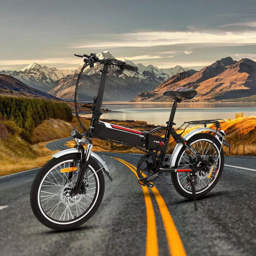

In [14]:
from fastdownload import download_url
dest = 'bicycle.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Trees:

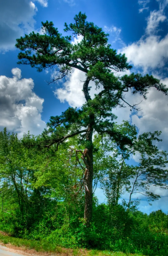

In [15]:
download_url(search_images('tree photos', max_images=1)[0], 'tree.jpg', show_progress=False)
Image.open('tree.jpg').to_thumb(256,256)

#### Download Data for both categories

In [16]:
searches = 'bicycle','tree'
path = Path('bicycle_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} morning photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} evening photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Use FastAI's utility to clean-up bad images that were not downloaded properly.

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

20

#### Create Data Blocks to train the network

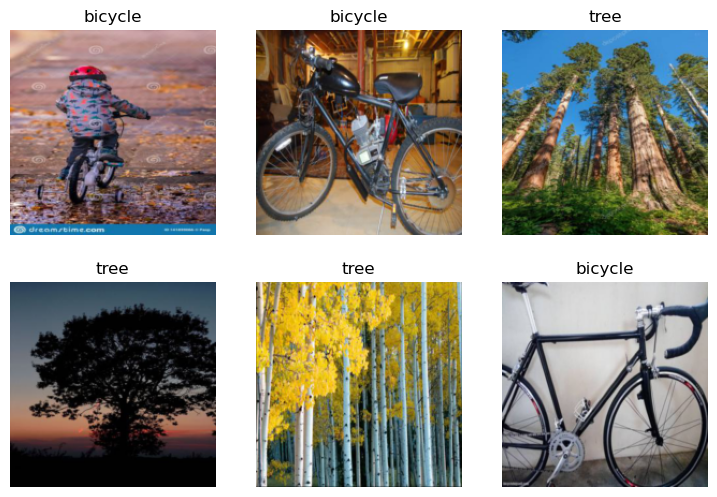

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Alright, we are all set to train our model.

# The CNN

We use `fast.ai` library to get access to popular Convolutional Neural Network architectures. The one we would use for this experiment is the `Resnet` architecture. More specifically, we are using the `Resnet 18` variant of that architecture, which is generally good enough for quick experiments. 

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)


/Users/gary/opt/anaconda3/envs/fastai-generic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/gary/opt/anaconda3/envs/fastai-generic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/gary/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [ ]:
learn.fine_tune(3)